##### Inspired by: [Towers of Hanoi (Wikipedia)](https://en.wikipedia.org/wiki/Tower_of_Hanoi)  and [Hanoi Graph (Wikipedia)](https://en.wikipedia.org/wiki/Hanoi_graph)

## Importing PWE and other essentials

In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_nb_helper import ASPRules
from copy import deepcopy

In [2]:
%load_ext PWE_NB_Extension

## Generating the encoding

Here we generate a encoding parametrized by the number of disks and pegs. Such encoding generators can especially be helpful in planning scenarios where one might want to "activate" some rules in certain states, etc.

Set the number of disks and pegs

In [3]:
NUM_DISKS = 3
NUM_PEGS = 3

Generate the rules

In [4]:
toh_edge_rules = []

# Add the schema information for the 'peg' relation
toh_edge_rules.append('% schema peg(PEG_ID)')

# Define the pegs as 'peg(a;b;c;...)'
toh_edge_rules.append('peg({}).'.format(';'.join([chr(ord('a')+i) for i in range(NUM_PEGS)])))

# Peg IDs for the disks i.e. [D1, D2, D3, ...]
start_state = ['D{}'.format(d+1) for d in range(NUM_DISKS)]

# Peg declaration for the disks i.e. ['peg(D1)', 'peg(D2)', 'peg(D3)', ...]
start_state_pegs = ['peg({})'.format(d) for d in start_state]

# Add schema information for the 'e' (edge) relation 
# i.e. % define e(DISK1_INIT_PEG, DISK2_INIT_PEG, ..., DISK1_END_PEG, DISK2_END_PEG, ...)
edge_init_col_names = ['DISK{}_INIT_PEG'.format(i) for i in range(1, NUM_DISKS+1)]
edge_end_col_names = ['DISK{}_END_PEG'.format(i) for i in range(1, NUM_DISKS+1)]
toh_edge_rules.append('% schema e({},{})'.format(','.join(edge_init_col_names), 
                                                 ','.join(edge_end_col_names)))

# Create the rules that define if a disk i can be moved
for i in range(NUM_DISKS):
    
    # Create Peg IDs for the end state i.e. ['D1',.., 'D{i-1}', 'D{i}_', 'D{i+1}',...]
    end_state = ['D{}'.format(d+1) if d != i else 'D{}_'.format(d+1) for d in range(NUM_DISKS)]
    # Pegs for end state i.e. ['peg(D1)', ..., 'peg(D{i})', ....]
    end_state_pegs = ['peg({})'.format(d) for d in end_state]
    # Checks that D{i} is unblocked i.e. ['D{i} != D1', 'D{i} != D2', ..., 'D{i} != D{i-1}']
    unblocked_checks = ['{} != {}'.format(start_state[i], start_state[j]) for j in range(0, i)]
    # Checks that D{i} is moving to a peg where it would be the smallest disk
    # i.e. ['D{i}_ != D1', 'D{i}_ != D2', ..., 'D{i}_ != D{i-1}']
    valid_move_checks = ['{} != {}'.format(end_state[i], start_state[j]) for j in range(0, i)]
    # Check that the init and end states are different i.e. 'D{i} != D{i}_'
    uniqueness_check = '{} != {}'.format(start_state[i], end_state[i])
    # Create the rule for disk i
    toh_edge_rules.append('e({0},{1}) :- {2}, {3}, {4}{5}{6}.'
                          .format(','.join(start_state), ','.join(end_state),
                                  ','.join(start_state_pegs), end_state_pegs[i], 
                                  uniqueness_check,
                                  ', {}'.format(', '.join(unblocked_checks)) 
                                      if len(unblocked_checks) > 0 else '',
                                  ', {}'.format(', '.join(valid_move_checks)) 
                                      if len(valid_move_checks) > 0 else ''))



#### So we end up with these rules

In [5]:
ASPRules('\n'.join(toh_edge_rules))

'% schema peg(PEG_ID)\npeg(a;b;c).\n% schema e(DISK1_INIT_PEG,DISK2_INIT_PEG,DISK3_INIT_PEG,DISK1_END_PEG,DISK2_END_PEG,DISK3_END_PEG)\ne(D1,D2,D3,D1_,D2,D3) :- peg(D1),peg(D2),peg(D3), peg(D1_), D1 != D1_.\ne(D1,D2,D3,D1,D2_,D3) :- peg(D1),peg(D2),peg(D3), peg(D2_), D2 != D2_, D2 != D1, D2_ != D1.\ne(D1,D2,D3,D1,D2,D3_) :- peg(D1),peg(D2),peg(D3), peg(D3_), D3 != D3_, D3 != D1, D3 != D2, D3_ != D1, D3_ != D2.'

#### Run these rules in clingo

In [6]:
%clingo -l toh_edge_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\npeg(a) peg(b) peg(c) e(c,c,b,c,c,a) e(b,b,c,b,b,a) e(c,c,a,c,c,b) e(a,a,c,a,a,b) e(b,b,a,b,b,c) e(a,a,b,a,a,c) e(c,b,a,c,a,a) e(b,c,a,b,a,a) e(c,b,b,c,a,b) e(b,c,b,b,a,b) e(c,b,c,c,a,c) e(b,c,c,b,a,c) e(c,a,a,c,b,a) e(a,c,a,a,b,a) e(c,a,b,c,b,b) e(a,c,b,a,b,b) e(c,a,c,c,b,c) e(a,c,c,a,b,c) e(b,a,a,b,c,a) e(a,b,a,a,c,a) e(b,a,b,b,c,b) e(a,b,b,a,c,b) e(b,a,c,b,c,c) e(a,b,c,a,c,c) e(b,a,a,a,a,a) e(c,a,a,a,a,a) e(b,b,a,a,b,a) e(c,b,a,a,b,a) e(b,c,a,a,c,a) e(c,c,a,a,c,a) e(b,a,b,a,a,b) e(c,a,b,a,a,b) e(b,b,b,a,b,b) e(c,b,b,a,b,b) e(b,c,b,a,c,b) e(c,c,b,a,c,b) e(b,a,c,a,a,c) e(c,a,c,a,a,c) e(b,b,c,a,b,c) e(c,b,c,a,b,c) e(b,c,c,a,c,c) e(c,c,c,a,c,c) e(a,a,a,b,a,a) e(c,a,a,b,a,a) e(a,b,a,b,b,a) e(c,b,a,b,b,a) e(a,c,a,b,c,a) e(c,c,a,b,c,a) e(a,a,b,b,a,b) e(c,a,b,b,a,b) e(a,b,b,b,b,b) e(c,b,b,b,b,b) e(a,c,b,b,c,b) e(c,c,b,b,c,b) e(a,a,c,b,a,c) e(c,a,c,b,a,c) e(a,b,c,b,b,c) e(c,b,c,b,b,c) e(a,c,c,b,c,c) e(c,c,c,b,c,c) e(a,a,a,c,a,a) e(b,a,a,c,a,a) e(a,b,a,c,b,a) e(b,b,a,c,b,a) e(a,c,a,c,c,a) e(b,c,a,c,c,a) e(a,a,b,c,a,b) e(b,a,b,c,a,b) e(a,b,b,c,b,b) e(b,b,b,c,b,b) e(a,c,b,c,c,b) e(b,c,b,c,c,b) e(a,a,c,c,a,c) e(b,a,c,c,a,c) e(a,b,c,c,b,c) e(b,b,c,c,b,c) e(a,c,c,c,c,c) e(b,c,c,c,c,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.008s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

In [7]:
meta_data

{'temporal_dec': {},
 'attr_def': {'peg_1': ['PEG_ID'],
  'e_6': ['DISK1_INIT_PEG',
   'DISK2_INIT_PEG',
   'DISK3_INIT_PEG',
   'DISK1_END_PEG',
   'DISK2_END_PEG',
   'DISK3_END_PEG']},
 'graphviz': {'graph': {'graph_type': 'undirected', 'styles': []},
  'node': {},
  'edge': {}}}

#### Load this solution i.e. the set of edges into PWE

In [8]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


In [9]:
pw_rels_dfs.keys()

dict_keys(['peg_1', 'e_6'])

In [10]:
edge_rel_name = 'e_{}'.format(2*NUM_DISKS)
edge_rel_name

'e_6'

And here's the set of edges created

In [11]:
pw_rels_dfs[edge_rel_name]

,pw,DISK1_INIT_PEG,DISK2_INIT_PEG,DISK3_INIT_PEG,DISK1_END_PEG,DISK2_END_PEG,DISK3_END_PEG
0,1,c,c,b,c,c,a
1,1,b,b,c,b,b,a
2,1,c,c,a,c,c,b
3,1,a,a,c,a,a,b
4,1,b,b,a,b,b,c
5,1,a,a,b,a,a,c
6,1,c,b,a,c,a,a
7,1,b,c,a,b,a,a
8,1,c,b,b,c,a,b
9,1,b,c,b,b,a,b


### Converting this into a networkx graph
This is desirable since it allows for further analysis of the resulting graph

Some imports required like networkx

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

Create the graph

In [13]:
G = nx.Graph()
edges = []
for i, row in pw_rels_dfs[edge_rel_name].iterrows():
    start_node = "{}".format(''.join([row[col] for col in edge_init_col_names]))
    end_node = "{}".format(''.join([row[col] for col in edge_end_col_names]))
    G.add_edge(start_node, end_node, penwidth=2)
    edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
G.graph['layout'] = 'neato'
G.graph['rankdir'] = 'TB'

Now let's visualize it!

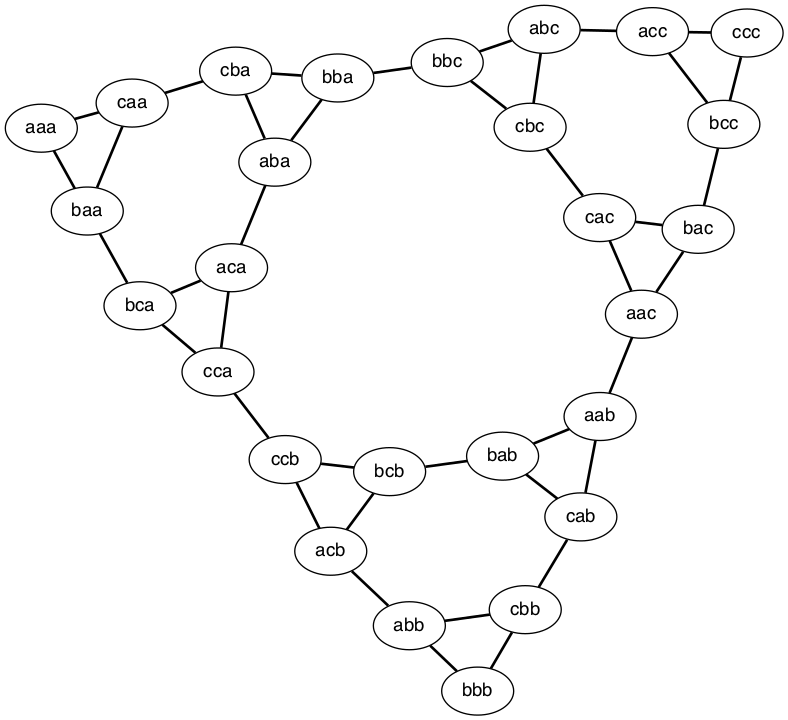

In [14]:
draw(G)

In [15]:
# To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G, format=f, filename='hanoi_graph.{}'.format(f), show='none')

Since we now have a networkx representation of this graph, we can conduct some cool analysis such as finding the shortest path between the start (aaa..) and end state (ccc...) of a TOH game.

In [16]:
shortest_path = list(nx.shortest_path(G, 'a'*NUM_DISKS, chr(ord('a')+NUM_PEGS-1)*NUM_DISKS))
print(' --> '.join(shortest_path))

aaa --> caa --> cba --> bba --> bbc --> abc --> acc --> ccc


In [17]:
shortest_path_edges = list(zip(shortest_path, shortest_path[1:]))

We can now visualize and highlight this path

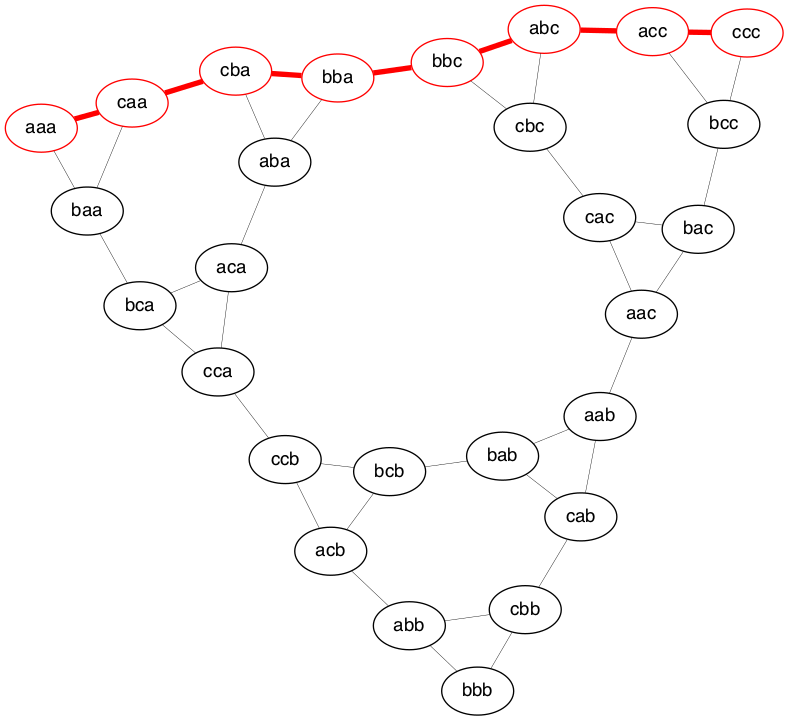

In [18]:
G_temp = deepcopy(G)
for node in shortest_path:
    G_temp.nodes[node]['color'] = 'red'
for edge in G_temp.edges:
    G_temp.edges[edge]['penwidth'] = 0.3
for edge in shortest_path_edges:
    G_temp.edges[edge]['color'] = 'red'
    G_temp.edges[edge]['penwidth'] = 4
draw(G_temp)

In [19]:
# To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G_temp, format=f, filename='hanoi_graph_shortest_path.{}'.format(f), show='none')

#### Additionally, a user may be interested in determining if there exists a sequence of moves that produces every possible state exactly once (and return to the original state at the end). As we know this is the Hamiltonian cycle problem. We can determine the existence of a Hamiltonian cycle in the Hanoi Graph as shown below.

#### Hamiltonian Cycle using ASP again!

We first import the Hamiltonian cycle encoding

In [20]:
%asp_loadfiles clingo_files/hamiltonian_cycle.lp4 -r clingo

In [21]:
%%clingo --donot-run --donot-display_input -lci hamil_cycle_rules

% http://www.cs.utexas.edu/~wcook/Courses/398T-F08/Lifschitz.pdf
n(X):- e(X,_).
n(X):- e(_,X).
1 { in(X,Y) ; out(X,Y) } 1 :- e(X,Y).

% start(1).  %% NEEDS TO BE PROVIDED
:- 2 {in(X,Y) : e(X,Y)}, n(X).
:- 2 {in(X,Y) : e(X,Y)}, n(Y).
r(X) :- in(Y,X), n(X), start(Y).
r(Y) :- r(X), in(X,Y), e(X,Y).
:- not r(X), n(X).
:- in(X,Y), in(Y,X).

#show in/2.

Next we create the 'e' (i.e. edge) and 'start' facts to go along with this encoding:

In [22]:
edge_fact_rules = []
for n1, n2 in edges:
    edge_fact_rules.append("e({},{}).".format(n1,n2))
start_rule = ['start({}).'.format(list(G.nodes)[0])]

Now we solve the above constraints using an ASP reasoner to get the Hamiltonian cycle: 

In [23]:
hamil_clingo_soln, hamil_meta_data = run_clingo(clingo_rules=edge_fact_rules+start_rule+hamil_cycle_rules.splitlines(), num_solutions=1)
ASPRules('\n'.join(hamil_clingo_soln))

'Answer: 1\nin(cca,ccb) in(bbc,bba) in(aab,aac) in(cba,caa) in(baa,bca) in(cbb,cab) in(bac,bcc) in(acb,abb) in(acc,abc) in(aaa,baa) in(caa,aaa) in(bba,aba) in(aba,cba) in(bca,aca) in(aca,cca) in(bab,aab) in(abb,bbb) in(bcb,acb) in(aac,cac) in(abc,cbc) in(ccc,acc) in(cab,bab) in(bbb,cbb) in(ccb,bcb) in(cac,bac) in(cbc,bbc) in(bcc,ccc)\nSATISFIABLE\n\nModels       : 1+\nCalls        : 1\nTime         : 0.006s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

In [24]:
hamil_pw_rels_dfs, hamil_rel_schemas, hamil_pw_objs = load_worlds(asp_output=hamil_clingo_soln, meta_data=hamil_meta_data, reasoner='clingo')

Number of Models: 1


In [25]:
hamil_pw_rels_dfs.keys()

dict_keys(['in_2'])

Following are the edges that are part of the Hamiltonian cycle:

In [26]:
hamil_pw_rels_dfs['in_2']

,pw,x1,x2
0,1,cca,ccb
1,1,bbc,bba
2,1,aab,aac
3,1,cba,caa
4,1,baa,bca
5,1,cbb,cab
6,1,bac,bcc
7,1,acb,abb
8,1,acc,abc
9,1,aaa,baa


We can now easily visualize this using networkx and nxpd again:

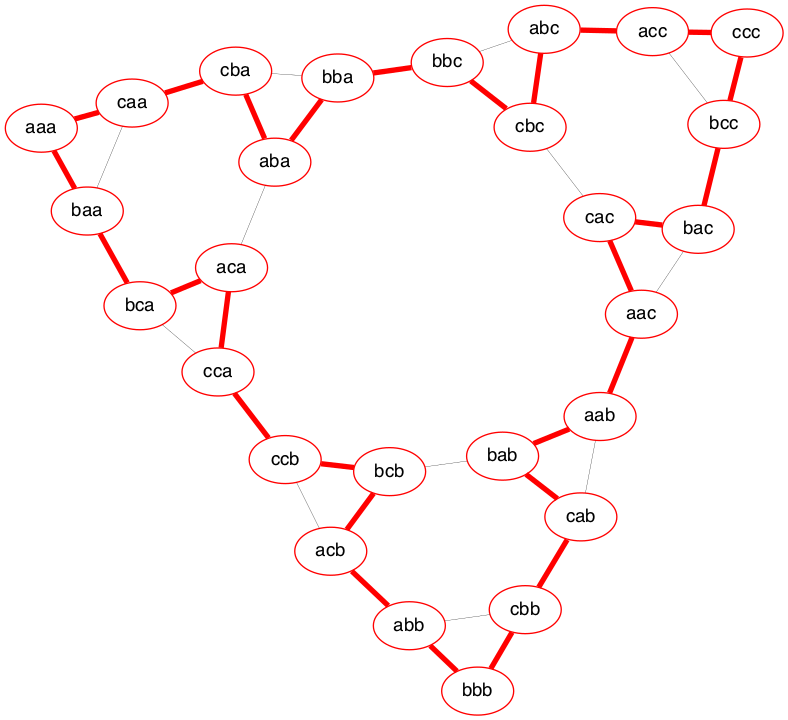

In [27]:
G_temp = deepcopy(G)
for node in G_temp.nodes:
    G_temp.nodes[node]['color'] = 'red'
for edge in G_temp.edges:
    G_temp.edges[edge]['penwidth'] = 0.2
for i, row in hamil_pw_rels_dfs['in_2'].iterrows():
    G_temp.edges[(row['x1'], row['x2'])]['color'] = 'red'
    G_temp.edges[(row['x1'], row['x2'])]['penwidth'] = 4
draw(G_temp)

In [28]:
# To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G_temp, format=f, filename='hanoi_graph_hamiltonian_cycle.{}'.format(f), show='none')

We can also focus on the edges part of the Hamiltonian cycle and erase the rest

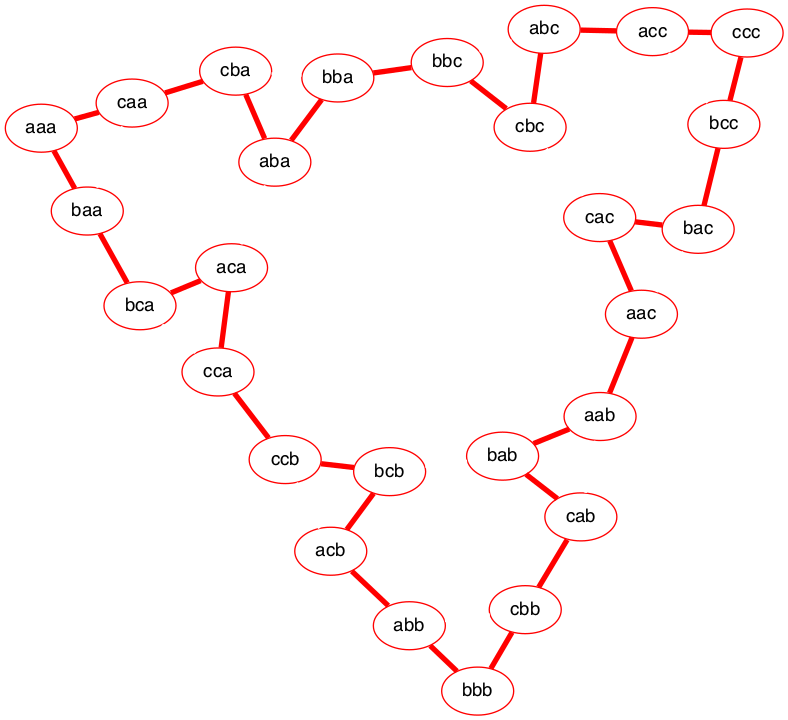

In [29]:
G_temp = deepcopy(G)
for node in G_temp.nodes:
    G_temp.nodes[node]['color'] = 'red'
for edge in G_temp.edges:
    G_temp.edges[edge]['color'] = '#ffffff'
for i, row in hamil_pw_rels_dfs['in_2'].iterrows():
    G_temp.edges[(row['x1'], row['x2'])]['color'] = 'red'
    G_temp.edges[(row['x1'], row['x2'])]['penwidth'] = 4
draw(G_temp)

In [30]:
# To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G_temp, format=f, filename='hanoi_graph_hamiltonian_cycle_focused.{}'.format(f), show='none')

#### Triangles!

Just like Hamiltonian cycle above, we can also find all the triangles in the Hanoi Graph using ASP again, as shown below.

We encode the triangle query as follows:

In [31]:
%%clingo -l edge_fact_rules --exp hanoi_triangles
tr(A,B,C) :- e(A,B), e(B,C), e(C,A), A != B, B != C, A != C, A > B, B > C.
#show tr/3.

Input:


'e(ccb,cca).\ne(bbc,bba).\ne(cca,ccb).\ne(aac,aab).\ne(bba,bbc).\ne(aab,aac).\ne(cba,caa).\ne(bca,baa).\ne(cbb,cab).\ne(bcb,bab).\ne(cbc,cac).\ne(bcc,bac).\ne(caa,cba).\ne(aca,aba).\ne(cab,cbb).\ne(acb,abb).\ne(cac,cbc).\ne(acc,abc).\ne(baa,bca).\ne(aba,aca).\ne(bab,bcb).\ne(abb,acb).\ne(bac,bcc).\ne(abc,acc).\ne(baa,aaa).\ne(caa,aaa).\ne(bba,aba).\ne(cba,aba).\ne(bca,aca).\ne(cca,aca).\ne(bab,aab).\ne(cab,aab).\ne(bbb,abb).\ne(cbb,abb).\ne(bcb,acb).\ne(ccb,acb).\ne(bac,aac).\ne(cac,aac).\ne(bbc,abc).\ne(cbc,abc).\ne(bcc,acc).\ne(ccc,acc).\ne(aaa,baa).\ne(caa,baa).\ne(aba,bba).\ne(cba,bba).\ne(aca,bca).\ne(cca,bca).\ne(aab,bab).\ne(cab,bab).\ne(abb,bbb).\ne(cbb,bbb).\ne(acb,bcb).\ne(ccb,bcb).\ne(aac,bac).\ne(cac,bac).\ne(abc,bbc).\ne(cbc,bbc).\ne(acc,bcc).\ne(ccc,bcc).\ne(aaa,caa).\ne(baa,caa).\ne(aba,cba).\ne(bba,cba).\ne(aca,cca).\ne(bca,cca).\ne(aab,cab).\ne(bab,cab).\ne(abb,cbb).\ne(bbb,cbb).\ne(acb,ccb).\ne(bcb,ccb).\ne(aac,cac).\ne(bac,cac).\ne(abc,cbc).\ne(bbc,cbc).\ne(acc,ccc).\ne(bcc,ccc).\ntr(A,B,C) :- e(A,B), e(B,C), e(C,A), A != B, B != C, A != C, A > B, B > C.\n#show tr/3.'

Output:


'Answer: 1\ntr(caa,baa,aaa) tr(cba,bba,aba) tr(cca,bca,aca) tr(cab,bab,aab) tr(cbb,bbb,abb) tr(ccb,bcb,acb) tr(cac,bac,aac) tr(cbc,bbc,abc) tr(ccc,bcc,acc)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [32]:
hanoi_triangles_pws_rel_dfs, _, _ = load_worlds(hanoi_triangles['asp_soln'])

Number of Models: 1


In [33]:
hanoi_triangles_pws_rel_dfs['tr_3']

,pw,x1,x2,x3
0,1,caa,baa,aaa
1,1,cba,bba,aba
2,1,cca,bca,aca
3,1,cab,bab,aab
4,1,cbb,bbb,abb
5,1,ccb,bcb,acb
6,1,cac,bac,aac
7,1,cbc,bbc,abc
8,1,ccc,bcc,acc


We can now enlist the set of triangles as shown below:

In [34]:
triangles = [[row['x1'], row['x2'], row['x3']] for _, row in hanoi_triangles_pws_rel_dfs['tr_3'].iterrows()]
triangles

[['caa', 'baa', 'aaa'],
 ['cba', 'bba', 'aba'],
 ['cca', 'bca', 'aca'],
 ['cab', 'bab', 'aab'],
 ['cbb', 'bbb', 'abb'],
 ['ccb', 'bcb', 'acb'],
 ['cac', 'bac', 'aac'],
 ['cbc', 'bbc', 'abc'],
 ['ccc', 'bcc', 'acc']]

As before, we can easily visualize these triangles using nxpd.

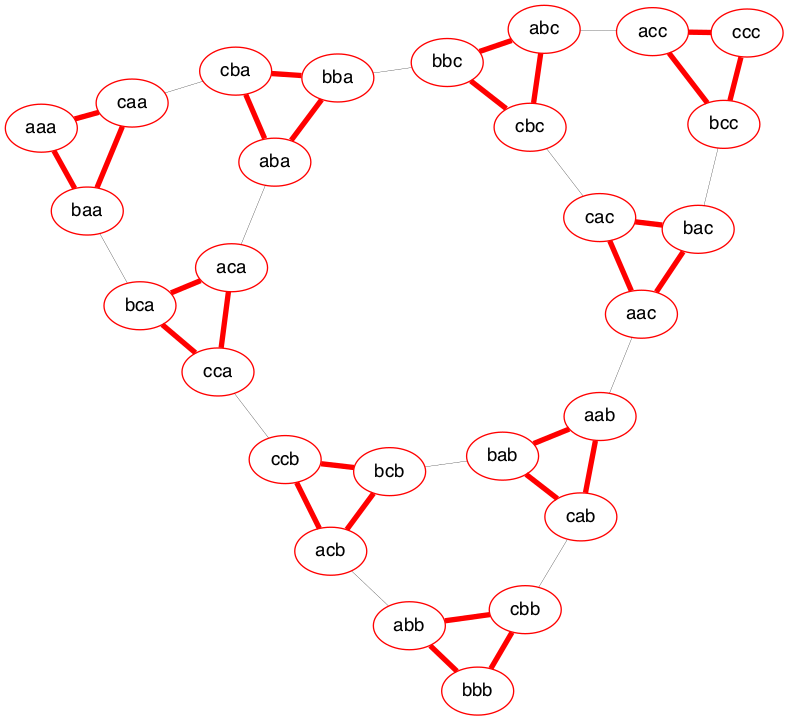

In [35]:
G_temp = deepcopy(G)
for edge in G_temp.edges:
    G_temp.edges[edge]['penwidth'] = 0.2
for tr in triangles:
    for n in tr:
        G_temp.nodes[n]['color'] = 'red'
    for e in [(tr[0], tr[1]), (tr[0], tr[2]), (tr[1], tr[2])]:
        G_temp.edges[e]['color'] = 'red'
        G_temp.edges[e]['penwidth'] = 4
draw(G_temp)

As can be observed above, each node is part of exactly one triangle and there are 9 triangles in this particular Hanoi Graph.

In [36]:
## To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G_temp, format=f, filename='hanoi_graph_triangles.{}'.format(f), show='none')